# Implementation of Freerider Detection using Quantum Computer

Through this notebook, I demonstarete quantum energy teleportation and implement the verification of energy consumption algorithm. 

Documentation: Ikeda, Kazuki, "Quantum Games and Economics through Teleportation" (March 06, 2025). Available at SSRN: https://ssrn.com/abstract_id=5168193

Copy right: Prof. Ikeda at UMass Boston (kazuki.ikeda@umb.edu)
Website: https://kazukiikeda.studio.site/

In [1]:
from QET import *

# Chose backend

In [2]:
simulator = Aer.get_backend('qasm_simulator')
pm = generate_preset_pass_manager(backend=simulator, optimization_level=3)
estimator = Estimator(simulator)

# Generate the ground state

In [3]:
# Set parameters
k=1
h=1.5

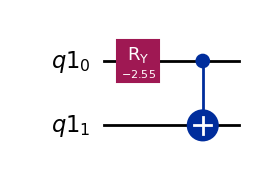

In [4]:
GS_Simulation = pm.run(minimal_model_ground_state_circuit(k,h))
GS_Simulation.draw("mpl", idle_wires=False)

In [5]:
observables_list=['XX','ZI','IZ']
observables=[SparsePauliOp(label) for label in observables_list]
mapped_observable = [observable.apply_layout(GS_Simulation.layout) for observable in observables]

In [6]:
GS_energy_Simulation = estimator.run([(GS_Simulation,mapped_observable)])

In [7]:
result_Simulation=GS_energy_Simulation.result()
gs_energy_Simulation=result_Simulation[0].data.evs

gs_energy_Simulation

array([-0.55126953, -0.84130859, -0.84130859])

In [8]:
2*k*gs_energy_Simulation[0]

-1.1025390625

In [9]:
Initial_Energy_Consumer=2*k*gs_energy_Simulation[0]+h*gs_energy_Simulation[1]
Initial_Energy_Consumer

-2.364501953125

In [10]:
Initial_Energy_Supplier=h*gs_energy_Simulation[2]
Initial_Energy_Supplier

-1.261962890625

# Quantum Energy Teleportation

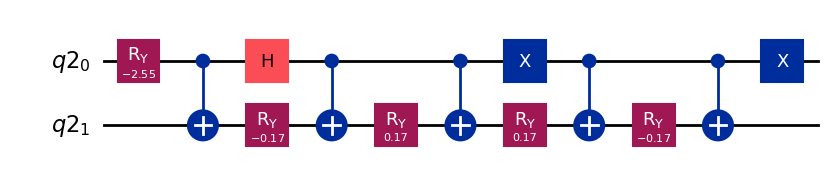

In [11]:
QET_Simulation = pm.run(QET_Estimator(k,h))
QET_Simulation.draw("mpl", idle_wires=False)

In [12]:
observables_list=['XZ','ZI','IZ']
observables=[SparsePauliOp(label) for label in observables_list]
mapped_observable = [observable.apply_layout(QET_Simulation.layout) for observable in observables]

In [13]:
QET_energy_Simulation= estimator.run([(QET_Simulation,mapped_observable)])

In [14]:
result=QET_energy_Simulation.result()
QET_energy=result[0].data.evs

QET_energy

array([-0.78808594, -0.60302734, -0.00244141])

In [15]:
Post_Energy_Consumer=2*k*QET_energy[0]+h*QET_energy[1]
Post_Energy_Consumer

-2.480712890625

In [16]:
Teleported_Energy=Post_Energy_Consumer-Initial_Energy_Consumer
Teleported_Energy

-0.1162109375

In [17]:
Post_Energy_Supplier=h*QET_energy[2]
Injected_Energy=Post_Energy_Supplier-Initial_Energy_Supplier
Injected_Energy

1.25830078125

# Combine QET with QST to confirm energy consumption

## Confirm energy consumption 

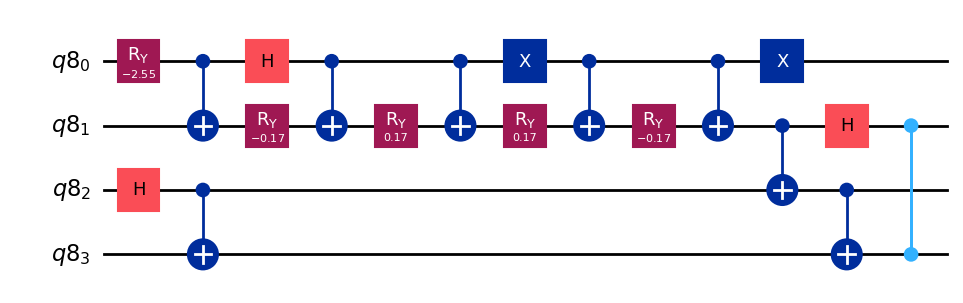

In [18]:
Confirm_QET_Simulation = pm.run(QET_QST_Estimator(k,h))
Confirm_QET_Simulation.draw("mpl", idle_wires=False)

In [19]:
observables_list=['XIIZ','ZIII']
observables=[SparsePauliOp(label) for label in observables_list]
mapped_observable = [observable.apply_layout(Confirm_QET_Simulation.layout) for observable in observables]

In [20]:
Confirmed_energy_Simulation = estimator.run([(Confirm_QET_Simulation,mapped_observable)])

In [21]:
result=Confirmed_energy_Simulation.result()
Confirmed_energy=result[0].data.evs

Confirmed_energy

array([-0.80517578, -0.59912109])

In [22]:
Confirmed_Energy_Consumer=2*k*Confirmed_energy[0]+h*Confirmed_energy[1]
Consumed_Energy=Confirmed_Energy_Consumer-Initial_Energy_Consumer
Consumed_Energy

-0.14453125

In [23]:
ratio=Consumed_Energy/Teleported_Energy
ratio

1.2436974789915967

## Confirmation of No Energy Consumption

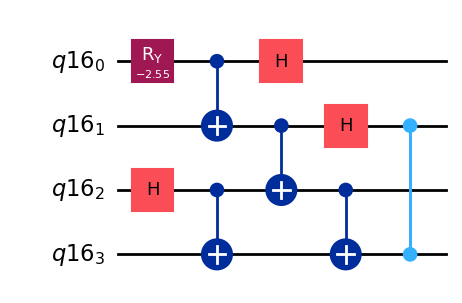

In [24]:
Confirm_NO_QET_Simulation = pm.run(Confirm_NO_QET_Estimator(k,h))
Confirm_NO_QET_Estimator(k,h).draw("mpl", idle_wires=False)

In [25]:
Confirmed_energy_Simulation = estimator.run([(Confirm_NO_QET_Simulation,mapped_observable)])

In [26]:
result=Confirmed_energy_Simulation.result()
Confirmed_energy=result[0].data.evs

Confirmed_energy

array([-0.55175781, -0.83056641])

In [27]:
Confirmed_Energy_Consumer=2*k*Confirmed_energy[0]+h*Confirmed_energy[1]
Consumed_Energy=Confirmed_Energy_Consumer-Initial_Energy_Consumer
Consumed_Energy

0.01513671875

# Experiment by Quantum Computer

In [57]:
# Enable your account on Qiskit, replace 'My_API_Token' with your newly generated token
from qiskit_ibm_experiment import IBMExperimentService
My_API_Token='Your token'
IBMExperimentService.save_account(token=My_API_Token,overwrite=True)

## Quantum Hardware

In [161]:
# Initialize the Qiskit runtime service
service = QiskitRuntimeService()
available_backends=service.backends()
backend = service.least_busy()
session = Session(backend=backend)
estimator = Estimator(mode=session)
sampler = Sampler(mode=session)

# Backend details
print("Available backends:",available_backends)
print("Name:", backend.name)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Available backends: [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_brussels')>, <IBMBackend('ibm_fez')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_strasbourg')>, <IBMBackend('ibm_torino')>]
Name: ibm_sherbrooke


In [59]:
service = QiskitRuntimeService()
#backend = service.backend("ibm_marrakesh")
backend = service.backend('ibm_strasbourg')
session = Session(backend=backend)
estimator = Estimator(mode=session)
sampler = Sampler(mode=session)

## Fake Hardware

In [33]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
#backend = FakeAlmadenV2()
#backend = Aer.get_backend('qasm_simulator')
backend = FakeSherbrooke()
shots = int(1e4)
estimator = Estimator(backend)
estimator.options.resilience_level = 2

## Pass Managers

In [65]:
pm1 = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout=[119,120])
pm2 = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout=[119,120,121,122])
                                                                            

## Ground State

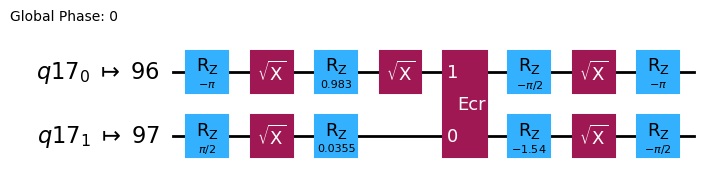

In [35]:
GS_QC = pm1.run(minimal_model_ground_state_circuit(k,h))
GS_QC.draw("mpl", idle_wires=False)

In [36]:
observables_list=['XZ','ZI','IZ']
observables=[SparsePauliOp(label) for label in observables_list]
mapped_observable = [observable.apply_layout(GS_QC.layout) for observable in observables]

In [37]:
GS_energy_QC = estimator.run([(GS_QC,mapped_observable)])

/Users/kazukiikeda/.pyenv/versions/3.12.1/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


In [38]:
result=GS_energy_QC.result()
gs_energy=result[0].data.evs

gs_energy

array([-0.00732422, -0.75341797, -0.76269531])

In [39]:
Initial_Energy_Consumer=2*k*gs_energy[0]+h*gs_energy[1]
Initial_Energy_Consumer

-1.144775390625

In [40]:
Initial_Energy_Supplier=h*gs_energy[2]
Initial_Energy_Supplier

-1.14404296875

## QET

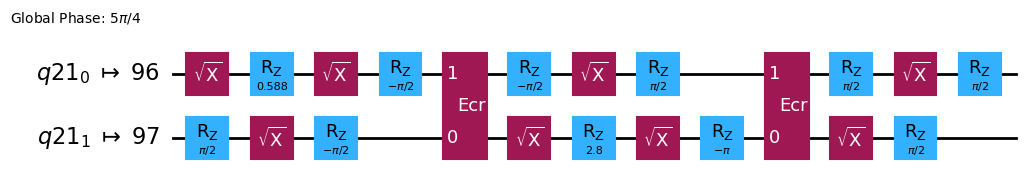

In [41]:
QET_QC = pm1.run(QET_Estimator(k,h))
QET_QC.draw("mpl", idle_wires=False)

In [42]:
observables_list=['XZ','ZI','IZ']
observables=[SparsePauliOp(label) for label in observables_list]
mapped_observable = [observable.apply_layout(QET_QC.layout) for observable in observables]

In [43]:
QET_energy_QC = estimator.run([(QET_QC,mapped_observable)])

/Users/kazukiikeda/.pyenv/versions/3.12.1/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


In [44]:
result=QET_energy_QC.result()
QET_energy=result[0].data.evs

QET_energy

array([-0.68359375, -0.52490234,  0.00683594])

In [45]:
Post_Energy_Consumer=2*k*QET_energy[0]+h*QET_energy[1]
Post_Energy_Consumer

-2.154541015625

In [46]:
Teleported_Energy=Post_Energy_Consumer-Initial_Energy_Consumer
Teleported_Energy

-1.009765625

In [47]:
Post_Energy_Supplier=h*QET_energy[2]
Injected_Energy=Post_Energy_Supplier-Initial_Energy_Supplier
Injected_Energy

1.154296875

## Confirm Energy

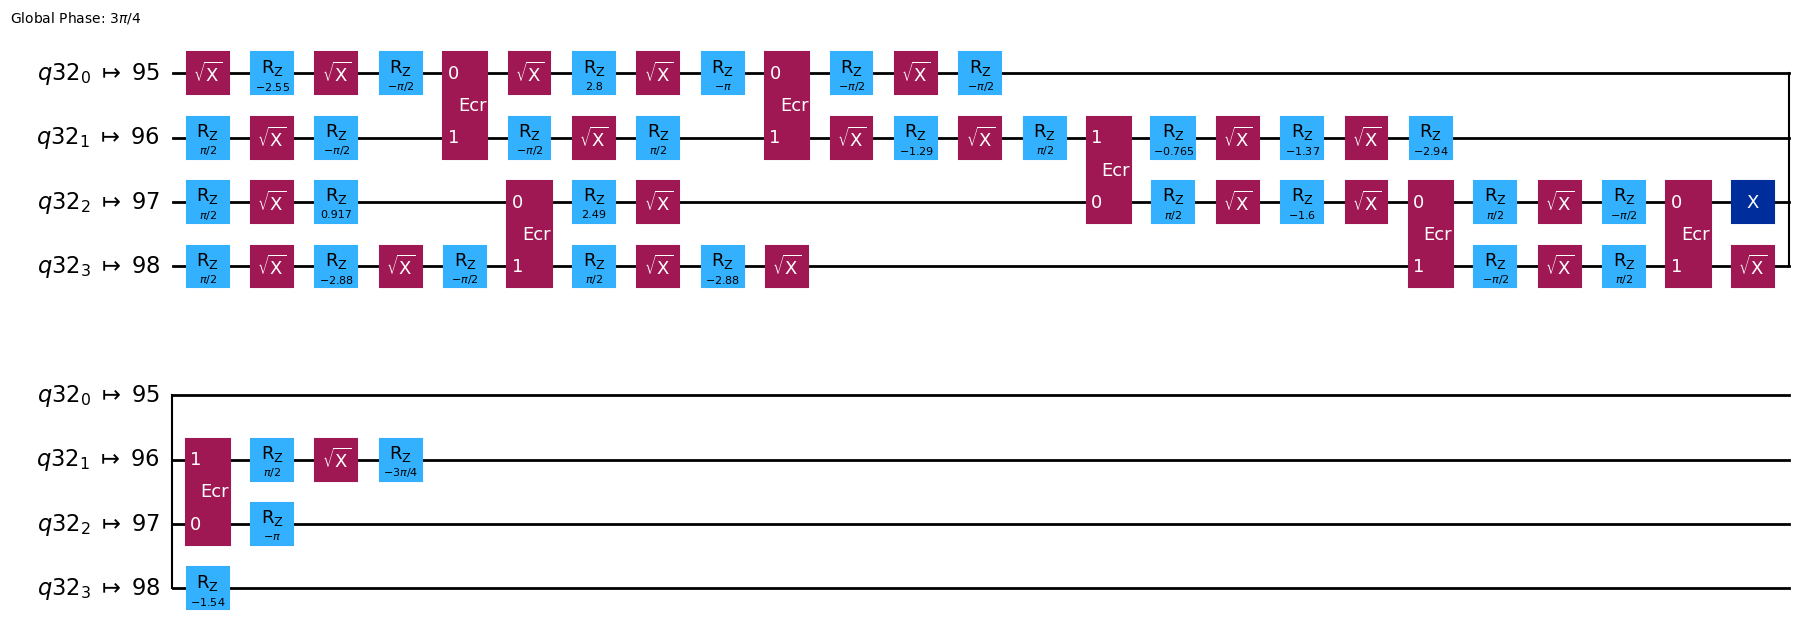

In [48]:
Confirm_QET_QC = pm2.run(QET_QST_Estimator(k,h))
Confirm_QET_QC.draw("mpl", idle_wires=False)

In [49]:
observables_list=['XIIZ','ZIII']
observables=[SparsePauliOp(label) for label in observables_list]
mapped_observable = [observable.apply_layout(Confirm_QET_QC.layout) for observable in observables]

In [50]:
Confirmed_energy_QC = estimator.run([(Confirm_QET_QC,mapped_observable)])

/Users/kazukiikeda/.pyenv/versions/3.12.1/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


In [51]:
result=Confirmed_energy_QC.result()
Confirmed_energy=result[0].data.evs

Confirmed_energy

array([-0.64257812, -0.48876953])

In [52]:
Confirmed_Energy_Consumer=2*k*Confirmed_energy[0]+h*Confirmed_energy[1]
Consumed_Energy=Confirmed_Energy_Consumer-Initial_Energy_Consumer
Consumed_Energy

-0.87353515625

In [53]:
ratio=Consumed_Energy/Teleported_Energy
ratio

0.8650870406189555

## Run QC

In [ ]:
# Initialize the Qiskit runtime service
service = QiskitRuntimeService()
available_backends=service.backends()
backend = service.least_busy()
session = Session(backend=backend)
estimator = Estimator(mode=session)
sampler = Sampler(mode=session)

# Backend details
print("Available backends:",available_backends)
print("Name:", backend.name)

estimator.options.resilience_level = 2
estimator.options.default_shots = 100,000

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
#backend = FakeAlmadenV2()
#backend = Aer.get_backend('qasm_simulator')
backend = FakeSherbrooke()
shots = int(1e5)

In [ ]:
backend = FakeSherbrooke()

In [66]:
estimator.options.default_shots = 100000
estimator = Estimator(backend)
estimator.options.resilience_level = 2
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XpXm"

estimator.options.twirling.enable_gates = True
estimator.options.twirling.num_randomizations = 32
#estimator.options.twirling.shots_per_randomization = 100

estimator.options.resilience.measure_mitigation = True
estimator.options.resilience.measure_noise_learning.num_randomizations = 32
estimator.options.resilience.measure_noise_learning.shots_per_randomization = 100

estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.noise_factors = (1, 2, 3)
estimator.options.resilience.zne.extrapolator = "linear"

estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.amplifier = "pea"


In [67]:
pm1 = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout=[119,120])
pm2 = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout=[119,120,121,122])

In [68]:
k=1
h=1.5

In [69]:
GS_QC = pm1.run(minimal_model_ground_state_circuit(k,h))
QET_QC = pm1.run(QET_Estimator(k,h))
Confirm_QET_QC = pm2.run(QET_QST_Estimator(k,h))
Confirm_NO_QET_QC = pm2.run(Confirm_NO_QET_Estimator(k,h))

In [70]:
observables_list0=['XX','ZI','IZ']
observables=[SparsePauliOp(label) for label in observables_list0]
mapped_observable0 = [observable.apply_layout(GS_QC.layout) for observable in observables]

observables_list1=['XZ','ZI','IZ']
observables=[SparsePauliOp(label) for label in observables_list1]
mapped_observable1 = [observable.apply_layout(QET_QC.layout) for observable in observables]

observables_list2=['XIIZ','ZIII']
observables=[SparsePauliOp(label) for label in observables_list2]
mapped_observable2 = [observable.apply_layout(Confirm_QET_QC.layout) for observable in observables]

observables_list2=['XIIZ','ZIII']
observables=[SparsePauliOp(label) for label in observables_list2]
mapped_observable3 = [observable.apply_layout(Confirm_NO_QET_QC.layout) for observable in observables]

In [71]:
# (GS_QC,mapped_observable0) Ground 
# (QET_QC,mapped_observable1) QET
# (Confirm_QET_QC,mapped_observable2) Confirm QET
# (Confirm_NO_QET_QC,mapped_observable3) Confirm no QET

TEST_QC = estimator.run([(GS_QC,mapped_observable0),(QET_QC,mapped_observable1),(Confirm_QET_QC,mapped_observable2),(Confirm_NO_QET_QC,mapped_observable3)])
print(f">>> Job ID: {TEST_QC.job_id()}")

>>> Job ID: cyfjwk29b62g0081ws2g


In [72]:
result=TEST_QC.result()
#result[0].data.evs, result[0].data.stds

In [73]:
# Ground State Energy
Initial_Energy_Consumer=2*k*result[0].data.evs[0]+h*result[0].data.evs[1]
Initial_Energy_Consumer

-3.8481137457137806

In [74]:
Initial_Energy_Supplier=h*result[0].data.evs[2]
Initial_Energy_Supplier

-2.0156996791944635

In [75]:
# Post Energy
result[1].data.evs, result[1].data.stds

(array([-1.30329403, -0.92686662,  0.02737266]),
 array([0.15791377, 0.33555245, 0.02711239]))

In [76]:
Post_Energy_Consumer=2*k*result[1].data.evs[0]+h*result[1].data.evs[1]
Post_Energy_Consumer

-3.996887994979174

In [77]:
Teleported_Energy=Post_Energy_Consumer-Initial_Energy_Consumer
Teleported_Energy

-0.14877424926539318

In [78]:
Post_Energy_Supplier=h*h*result[1].data.evs[2]
Injected_Energy=Post_Energy_Supplier-Initial_Energy_Supplier
Injected_Energy

2.0772881748585803

In [79]:
result[2].data.evs, result[2].data.stds

(array([-0.9570403 , -0.70798499]), array([0.37250321, 0.35073205]))

In [80]:
Confirmed_Energy_Consumer=2*k*result[2].data.evs[0]+h*result[2].data.evs[1]
Consumed_Energy=Confirmed_Energy_Consumer-Initial_Energy_Consumer
Consumed_Energy, Consumed_Energy/Teleported_Energy

(0.8720556578159226, -5.86160348394898)

In [81]:
result[3].data.evs, result[3].data.stds

(array([-0.6361117, -1.1242221]), array([0.24826187, 0.43729686]))

In [82]:
NO_Energy_Consumer=2*k*result[3].data.evs[0]+h*result[3].data.evs[1]
NO_Consumed_Energy=NO_Energy_Consumer-Initial_Energy_Consumer
NO_Consumed_Energy

0.8895572058201755